In [ ]:
import pandas as pd

# Load the CSV files
new_file_path1 = '/content/drive/MyDrive/2019-Oct.csv'
new_file_path2 = '/content/drive/MyDrive/2019-Nov.csv'
new_file_path3 = '/content/drive/MyDrive/2019-Dec.csv'
new_file_path4 = '/content/drive/MyDrive/2020-Jan.csv'
new_file_path5 = '/content/drive/MyDrive/2020-Feb.csv'

# Read the CSV files into dataframes
new_data1 = pd.read_csv(new_file_path1)
new_data2 = pd.read_csv(new_file_path2)
new_data3 = pd.read_csv(new_file_path3)
new_data4 = pd.read_csv(new_file_path4)
new_data5 = pd.read_csv(new_file_path5)

# Combine the dataframes
combined_df = pd.concat([new_data1, new_data2, new_data3, new_data4, new_data5], ignore_index=True)

# Display the first few rows of the combined dataframe
combined_df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,cart,5773203,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
1,2019-10-01 00:00:03 UTC,cart,5773353,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
2,2019-10-01 00:00:07 UTC,cart,5881589,2151191071051219817,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
3,2019-10-01 00:00:07 UTC,cart,5723490,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
4,2019-10-01 00:00:15 UTC,cart,5881449,1487580013522845895,NaN,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9


In [ ]:
# Filter for purchase events
purchase_events = combined_df[combined_df['event_type'] == 'cart']
purchase_events['event_time'] = pd.to_datetime(purchase_events['event_time'])
purchase_events.set_index('event_time', inplace=True)
daily_purchases = purchase_events.resample('D').size()

<ipython-input-2-94471b500987>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchase_events['event_time'] = pd.to_datetime(purchase_events['event_time'])


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(daily_purchases.values.reshape(-1, 1))

In [ ]:
# Prepare the data for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

In [ ]:
# Split data into training and testing sets
training_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - training_size
train_data, test_data = scaled_data[0:training_size, :], scaled_data[training_size:len(scaled_data), :]


In [ ]:
# Create dataset for LSTM
time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
# Build the LSTM model
from tensorflow.keras.layers import LSTM, Dense, Dropout # Import Dropout

model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))  # Adding dropout to prevent overfitting
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 10, 100)             │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 10, 100)             │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 152,701 (596.49 KB)

 Trainable params: 152,701 (596.49 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=50)


Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0301
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0200
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0256
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0192
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0122
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0140
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0133
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0105
Epoch 9/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0279
Epoch 10/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0101
Epoch 11/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0116
Epoch 12/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0135
Epoch 13/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0132
Epoch 14/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0144
Epoch 15/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s

In [ ]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [ ]:
# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))


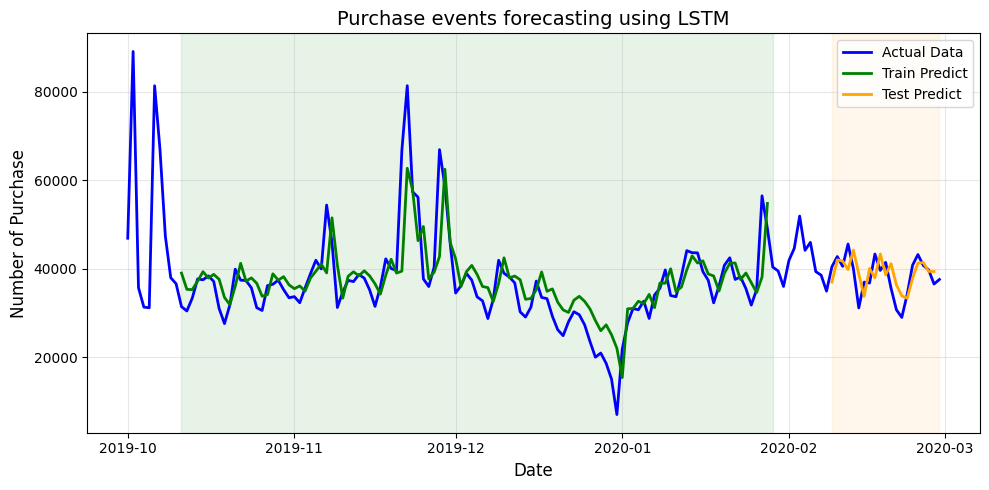

In [ ]:
# Enhanced Plot for Cart Forecasting using LSTM
plt.figure(figsize=(10, 5))

# Actual data
plt.plot(
    daily_purchases.index,
    daily_purchases.values,
    label='Actual Data',
    color='blue',
    alpha=1,
    linewidth=2
)

# Training predictions
plt.plot(
    daily_purchases.index[time_step:len(train_predict) + time_step],
    train_predict,
    label='Train Predict',
    color='green',
    linewidth=2,
    alpha=1
)

# Testing predictions
plt.plot(
    daily_purchases.index[len(train_predict) + (time_step * 2) + 1:len(daily_purchases) - 1],
    test_predict,
    label='Test Predict',
    color='orange',
    linewidth=2,
    alpha=1
)

# Highlight training range
plt.axvspan(
    daily_purchases.index[time_step],
    daily_purchases.index[len(train_predict) + time_step],
    color='green',
    alpha=0.09,
 #   label='Training Range'
)

# Highlight testing range
plt.axvspan(
    daily_purchases.index[len(train_predict) + (time_step * 2) + 1],
    daily_purchases.index[-1],
    color='orange',
    alpha=0.08,
   # label='Testing Range'
)

# Add legend in the upper-right corner
plt.legend(loc='upper right', fontsize=10)

# Add title, labels, and gridlines
plt.title('Purchase events forecasting using LSTM', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Purchase', fontsize=12)
plt.grid(alpha=0.3)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


Train MAE: 4223.701180752841
Train MSE: 39373412.873411156
Train RMSE: 6274.823732457443
Train MAPE: 13.525889800508285%
Train SMAPE: 12.069544743389814%

Test MAE: 3355.620703125
Test MSE: 15191809.069250489
Test RMSE: 3897.6671316635657
Test MAPE: 9.11882499062864%
Test SMAPE: 8.8579849019233%


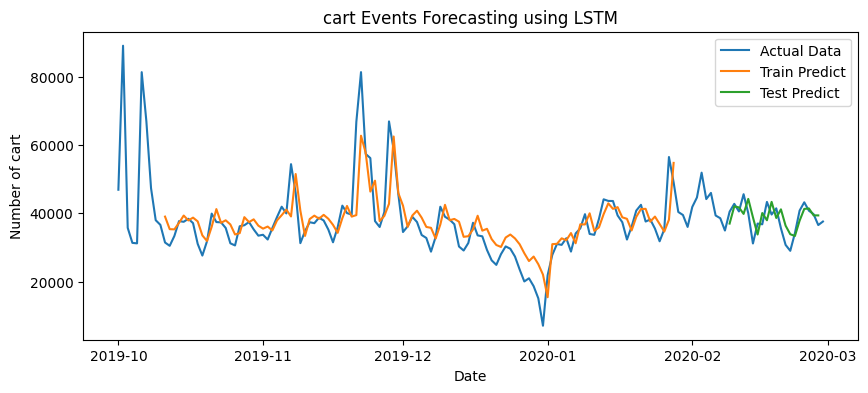

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression

# Calculate the error metrics
train_mae = mean_absolute_error(y_train, train_predict)
train_mse = mean_squared_error(y_train, train_predict)
train_rmse = np.sqrt(train_mse)

test_mae = mean_absolute_error(y_test, test_predict)
test_mse = mean_squared_error(y_test, test_predict)
test_rmse = np.sqrt(test_mse)

# Calculate MAPE
train_mape = np.mean(np.abs((y_train - train_predict) / y_train)) * 100
test_mape = np.mean(np.abs((y_test - test_predict) / y_test)) * 100

# Calculate SMAPE
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

train_smape = smape(y_train, train_predict)
test_smape = smape(y_test, test_predict)

# Print the error metrics
print(f"Train MAE: {train_mae}")
print(f"Train MSE: {train_mse}")
print(f"Train RMSE: {train_rmse}")
print(f"Train MAPE: {train_mape}%")
print(f"Train SMAPE: {train_smape}%")
print()
print(f"Test MAE: {test_mae}")
print(f"Test MSE: {test_mse}")
print(f"Test RMSE: {test_rmse}")
print(f"Test MAPE: {test_mape}%")
print(f"Test SMAPE: {test_smape}%")

# Plot the results
plt.figure(figsize=(10, 4))
plt.plot(daily_purchases.index, daily_purchases.values, label='Actual Data')
plt.plot(daily_purchases.index[time_step:len(train_predict) + time_step], train_predict, label='Train Predict')
plt.plot(daily_purchases.index[len(train_predict) + (time_step * 2) + 1:len(daily_purchases) - 1], test_predict, label='Test Predict')
plt.legend()
plt.title('cart Events Forecasting using LSTM')
plt.xlabel('Date')
plt.ylabel('Number of cart')
plt.show()

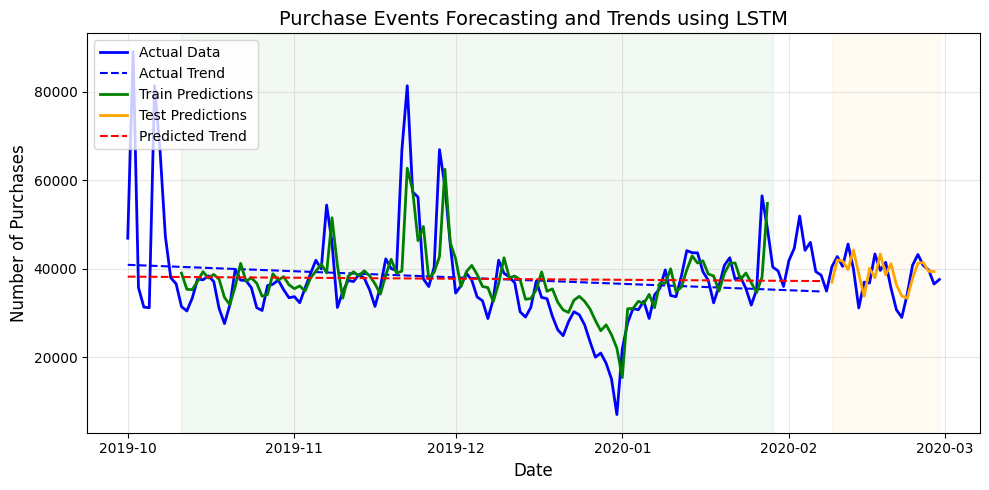

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Define trend line function
def plot_trend_line(data, label):
    x = np.arange(len(data)).reshape(-1, 1)
    y = data
    model = LinearRegression()
    model.fit(x, y)
    trend = model.predict(x)
    return trend

# Align the predicted data for trend plotting
all_predict = np.concatenate((train_predict, test_predict)).flatten()
all_actual = daily_purchases.values[time_step:len(train_predict) + len(test_predict) + time_step]

# Ensure the lengths match for trend plotting
aligned_actual = daily_purchases.values[:len(all_predict)]

# Calculate trends
actual_trend = plot_trend_line(aligned_actual, 'Actual Trend')
predicted_trend = plot_trend_line(all_predict, 'Predicted Trend')

# Plot data with improved visualization
plt.figure(figsize=(10, 5))

# Actual data and trend
plt.plot(
    daily_purchases.index,
    daily_purchases.values,
    label='Actual Data',
    color='blue',
    alpha=1,
    linewidth=2
)
plt.plot(
    daily_purchases.index[:len(actual_trend)],
    actual_trend,
    label='Actual Trend',
    linestyle='dashed',
    color='blue',
    alpha=1
)

# Train predictions
plt.plot(
    daily_purchases.index[time_step:len(train_predict) + time_step],
    train_predict,
    label='Train Predictions',
    color='green',
    linewidth=2,
    alpha=1
)

# Test predictions
plt.plot(
    daily_purchases.index[len(train_predict) + (time_step * 2) + 1:len(daily_purchases) - 1],
    test_predict,
    label='Test Predictions',
    color='orange',
    linewidth=2,
    alpha=1
)

# Predicted trend
plt.plot(
    daily_purchases.index[:len(predicted_trend)],
    predicted_trend,
    label='Predicted Trend',
    linestyle='dashed',
    color='red',
    alpha=1
)

# Add shaded regions for train and test segments
plt.axvspan(
    daily_purchases.index[time_step],
    daily_purchases.index[len(train_predict) + time_step],
    color='green',
    alpha=0.05,
    #label='Training Range'
)
plt.axvspan(
    daily_purchases.index[len(train_predict) + (time_step * 2) + 1],
    daily_purchases.index[-1],
    color='orange',
    alpha=0.05,
    #label='Testing Range'
)

# Add legend, labels, and title
plt.legend(loc='upper left')
plt.title('Purchase Events Forecasting and Trends using LSTM', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Purchases', fontsize=12)
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()
